# App Store Digital Health Apps Analysis

This notebook demonstrates how to:
1. Search for "digital health" apps in the Apple App Store
2. Scrape reviews for each app
3. Analyze the review data using pandas and numpy
4. Visualize insights from the reviews


## 1. Setup and Installation

First, let's install the required packages.

In [1]:
# Install required packages
!pip install app-store-scraper pandas numpy matplotlib seaborn nltk wordcloud tqdm ipywidgets

  Using cached urllib3-1.25.11-py2.py3-none-any.whl.metadata (41 kB)
Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from tqdm.notebook import tqdm
import re
import time
import json
import datetime
from app_store_scraper import AppStore

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

/Users/seanmacbook/GitHub/healthapp_web_scrapper/.venv/lib/python3.13/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 2. Searching for Digital Health Apps

To find all apps related to "digital health", we need to search the App Store. Since `app_store_scraper` doesn't have a direct search function for discovering apps, we'll use a workaround approach with a list of common digital health app names and search terms.

In [4]:
# Let's define a list of common digital health app categories and search terms
search_terms = [
    "digital health", 
    "health tracker", 
    "medical records", 
    "telemedicine", 
    "mental health", 
    "fitness tracker", 
    "meditation", 
    "sleep tracker", 
    "pill reminder", 
    "health monitoring",
    "doctor appointment",
    "wellness app"
]

# Since app_store_scraper doesn't have a direct search function,
# we'll use a known list of popular health apps and expand it with our search terms
known_health_apps = [
    {"name": "MyFitnessPal", "id": 341232718, "country": "us"},
    {"name": "Calm", "id": 571800810, "country": "us"},
    {"name": "Headspace", "id": 493145008, "country": "us"},
    {"name": "Fitbit", "id": 462638897, "country": "us"},
    {"name": "Apple Health", "id": 1242545199, "country": "us"},
    {"name": "Medisafe", "id": 573916946, "country": "us"},
    {"name": "Flo", "id": 1038369065, "country": "us"},
    {"name": "Teladoc", "id": 656872607, "country": "us"},
    {"name": "Mayo Clinic", "id": 312557633, "country": "us"},
    {"name": "WebMD", "id": 295076329, "country": "us"},
    {"name": "Sleep Cycle", "id": 320606217, "country": "us"},
    {"name": "Clue", "id": 657189652, "country": "us"},
    {"name": "Lose It!", "id": 297368629, "country": "us"},
    {"name": "Doximity", "id": 393642611, "country": "us"},
    {"name": "Noom", "id": 634598719, "country": "us"},
    {"name": "Talkspace", "id": 661681264, "country": "us"},
    {"name": "BetterHelp", "id": 995252384, "country": "us"},
    {"name": "7 Minute Workout", "id": 650762525, "country": "us"},
    {"name": "Peloton", "id": 792750948, "country": "us"},
    {"name": "Glucose Buddy", "id": 294754639, "country": "us"}
]

## 3. Retrieve App Details and Reviews

Now we'll iterate through the list of known health apps and scrape their details and reviews.

In [5]:
# Function to get app details and reviews
def get_app_details_and_reviews(app_info, max_reviews=100):
    """
    Scrapes app details and reviews using app_store_scraper
    
    Args:
        app_info (dict): Dictionary containing app name, id, and country
        max_reviews (int): Maximum number of reviews to scrape
        
    Returns:
        tuple: App details and DataFrame of reviews
    """
    try:
        # Initialize scraper for the app
        app = AppStore(country=app_info['country'], 
                       app_name=app_info['name'], 
                       app_id=app_info['id'])
        
        # Get app details
        app_details = {
            'name': app_info['name'],
            'id': app_info['id'],
            'country': app_info['country']
        }
        
        # Scrape reviews
        app.review(how_many=max_reviews)  # This will get up to max_reviews
        
        # Convert to DataFrame
        reviews_df = pd.DataFrame(app.reviews)
        
        # Add app info to reviews
        reviews_df['app_name'] = app_info['name']
        reviews_df['app_id'] = app_info['id']
        
        return app_details, reviews_df
    
    except Exception as e:
        print(f"Error scraping {app_info['name']}: {str(e)}")
        return app_info, pd.DataFrame()

# Scrape data for each app with error handling and rate limiting
all_apps_details = []
all_reviews = []

# Use tqdm for progress tracking
for app_info in tqdm(known_health_apps, desc="Scraping apps"):
    app_details, reviews_df = get_app_details_and_reviews(app_info, max_reviews=200)  # Limit to 200 reviews per app for demonstration
    
    if not reviews_df.empty:
        all_apps_details.append(app_details)
        all_reviews.append(reviews_df)
    
    # Add delay to avoid rate limiting
    time.sleep(2)  # 2-second delay between requests

# Combine all reviews into a single DataFrame
if all_reviews:
    reviews_df = pd.concat(all_reviews, ignore_index=True)
    print(f"Total apps scraped: {len(all_apps_details)}")
    print(f"Total reviews collected: {len(reviews_df)}")
else:
    reviews_df = pd.DataFrame()
    print("No reviews were collected.")

Scraping apps:   0%|          | 0/20 [00:00<?, ?it/s]

2025-04-07 17:13:35,403 [INFO] Base - Initialised: AppStore('us', 'myfitnesspal', 341232718)
2025-04-07 17:13:35,404 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/myfitnesspal/id341232718
2025-04-07 17:13:39,059 [INFO] Base - [id:341232718] Fetched 200 reviews (200 fetched in total)
2025-04-07 17:13:41,556 [INFO] Base - Initialised: AppStore('us', 'calm', 571800810)
2025-04-07 17:13:41,557 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/calm/id571800810
2025-04-07 17:13:44,624 [INFO] Base - [id:571800810] Fetched 200 reviews (200 fetched in total)
2025-04-07 17:13:48,009 [INFO] Base - Initialised: AppStore('us', 'headspace', 493145008)
2025-04-07 17:13:48,010 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/headspace/id493145008
2025-04-07 17:13:51,320 [INFO] Base - [id:493145008] Fetched 200 reviews (200 fetched in total)
2025-04-07 17:13:53,921 [INFO] Base - Initialised: AppStore('us', 'fitbit', 462638897)
20

Total apps scraped: 18
Total reviews collected: 3600


### Save the collected data
Let's save our scraped data to files for future use.

In [6]:
# Save the data to files
if not reviews_df.empty:
    # Save app details
    with open('app_store_digital_health_apps.json', 'w') as f:
        json.dump(all_apps_details, f)
    
    # Save reviews
    reviews_df.to_csv('../data/interim/app_store_digital_health_app_reviews.csv', index=False)
    reviews_df.to_pickle('app_store_digital_health_app_reviews.pkl')  # For faster loading in the future
    
    print("Data saved to files successfully!")

Data saved to files successfully!


## 4. Data Exploration and Cleaning

Now let's explore and clean the data we've collected.

In [7]:
# Check the DataFrame structure
if not reviews_df.empty:
    print("DataFrame shape:", reviews_df.shape)
    print("\nColumns in the DataFrame:")
    for col in reviews_df.columns:
        print(f"- {col}")
    
    # Display first few rows
    reviews_df.head()

DataFrame shape: (3600, 9)

Columns in the DataFrame:
- date
- review
- rating
- isEdited
- title
- userName
- developerResponse
- app_name
- app_id


In [8]:
# Clean and preprocess the data
if not reviews_df.empty:
    # Convert date columns to datetime
    if 'date' in reviews_df.columns:
        reviews_df['date'] = pd.to_datetime(reviews_df['date'])
    
    # Extract year and month for time-based analysis
    if 'date' in reviews_df.columns:
        reviews_df['year'] = reviews_df['date'].dt.year
        reviews_df['month'] = reviews_df['date'].dt.month
        reviews_df['year_month'] = reviews_df['date'].dt.strftime('%Y-%m')
    
    # Clean review text
    if 'review' in reviews_df.columns:
        # Remove special characters and extra spaces
        reviews_df['clean_review'] = reviews_df['review'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
        reviews_df['clean_review'] = reviews_df['clean_review'].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip())
        
        # Calculate review length
        reviews_df['review_length'] = reviews_df['clean_review'].apply(len)
        reviews_df['word_count'] = reviews_df['clean_review'].apply(lambda x: len(str(x).split()))
    
    # Check for missing values
    print("\nMissing values per column:")
    print(reviews_df.isnull().sum())


Missing values per column:
date                    0
review                  0
rating                  0
isEdited                0
title                   0
userName                0
developerResponse    2433
app_name                0
app_id                  0
year                    0
month                   0
year_month              0
clean_review            0
review_length           0
word_count              0
dtype: int64


## 5. Basic Analysis of App Reviews

Let's analyze the distribution of ratings and review trends.

2025-04-07 17:34:33,455 [INFO] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/hb/4s6bp6_s2018cs25zb9xhyvh0000gn/T/ipykernel_98032/4165679081.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=reviews_df, palette='viridis')
2025-04-07 17:34:33,461 [INFO] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


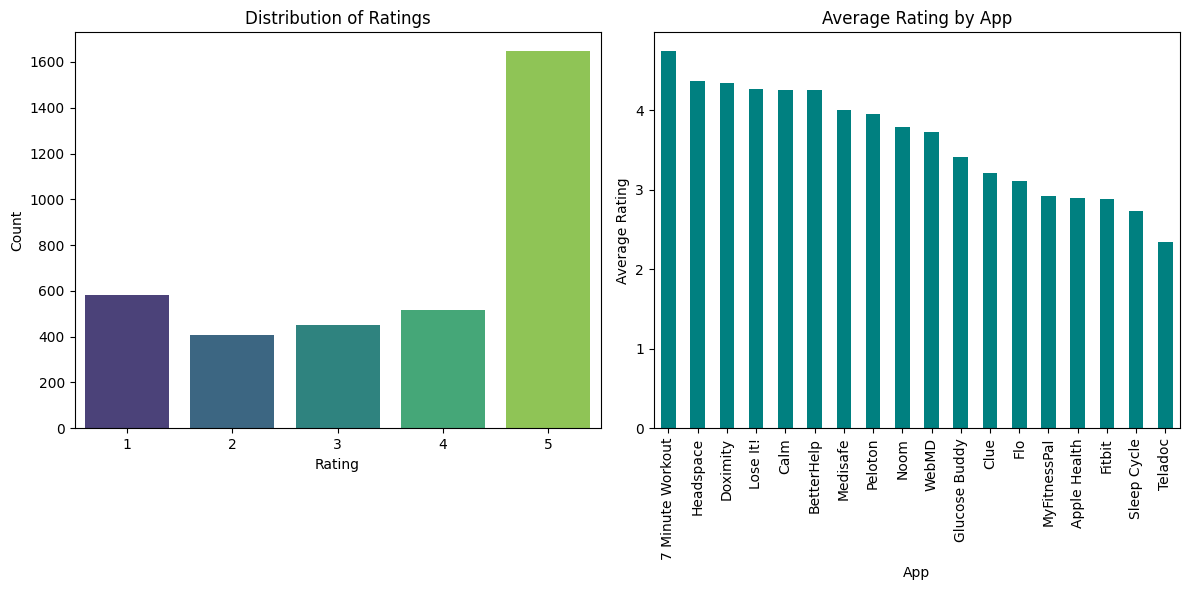

Rating Summary Statistics:
count    3600.000000
mean        3.623333
std         1.530576
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

Percentage of ratings:
Rating 1: 16.11%
Rating 2: 11.28%
Rating 3: 12.53%
Rating 4: 14.33%
Rating 5: 45.75%


In [9]:
# Analysis of ratings distribution
if not reviews_df.empty and 'rating' in reviews_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Overall rating distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x='rating', data=reviews_df, palette='viridis')
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    
    # Average rating by app
    plt.subplot(1, 2, 2)
    avg_ratings = reviews_df.groupby('app_name')['rating'].mean().sort_values(ascending=False)
    avg_ratings.plot(kind='bar', color='teal')
    plt.title('Average Rating by App')
    plt.xlabel('App')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("Rating Summary Statistics:")
    print(reviews_df['rating'].describe())
    
    # Calculate percentage of ratings by category
    rating_counts = reviews_df['rating'].value_counts().sort_index()
    rating_percentages = rating_counts / rating_counts.sum() * 100
    
    print("\nPercentage of ratings:")
    for rating, percentage in rating_percentages.items():
        print(f"Rating {rating}: {percentage:.2f}%")

NameError: name 'top_10_apps' is not defined

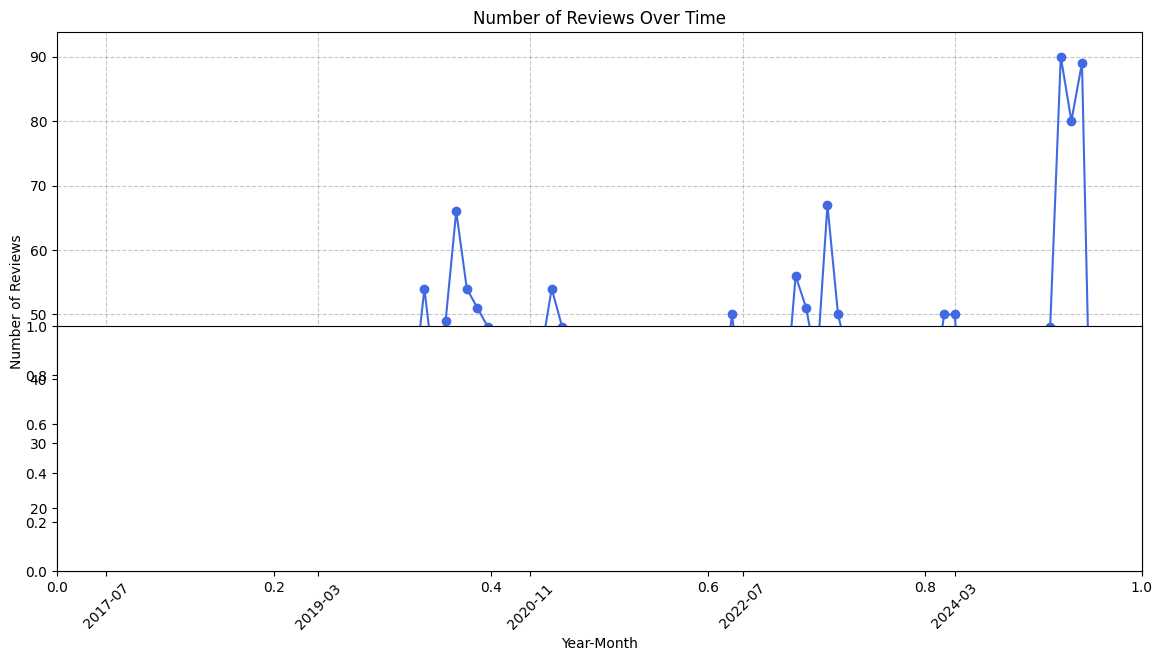

In [10]:
# Time-based analysis of reviews
if not reviews_df.empty and 'date' in reviews_df.columns:
    plt.figure(figsize=(14, 7))
    
    # Reviews over time
    reviews_by_month = reviews_df.groupby('year_month').size()
    reviews_by_month.plot(kind='line', marker='o', color='royalblue')
    plt.title('Number of Reviews Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    # Top 10 apps comparison
    plt.subplot(2, 1, 2)
    sns.barplot(x='app_name', y='avg_rating', data=top_10_apps, palette='viridis')
    plt.title('Top 10 Apps by Average Rating')
    plt.xlabel('App Name')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    plt.tight_layout()
    plt.show()
    
    # Average rating over time
    plt.figure(figsize=(14, 7))
    avg_rating_by_month = reviews_df.groupby('year_month')['rating'].mean()
    avg_rating_by_month.plot(kind='line', marker='o', color='green')
    plt.title('Average Rating Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Rating')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(1, 5)
    
    plt.tight_layout()
    plt.show()

## 6. Sentiment Analysis of Reviews

Let's analyze the sentiment of the reviews using NLTK's VADER sentiment analyzer.

/var/folders/hb/4s6bp6_s2018cs25zb9xhyvh0000gn/T/ipykernel_98032/1639738410.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_category', data=reviews_df, palette='RdYlGn')


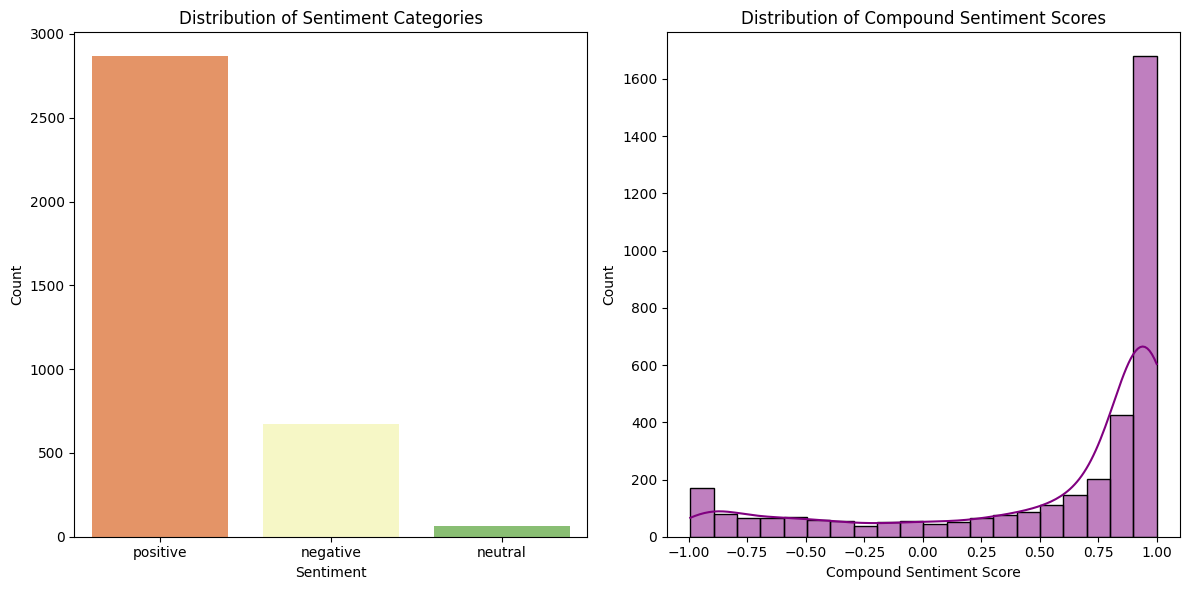

2025-04-07 17:34:37,525 [INFO] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/hb/4s6bp6_s2018cs25zb9xhyvh0000gn/T/ipykernel_98032/1639738410.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rating', y='compound_sentiment', data=reviews_df, palette='viridis')
2025-04-07 17:34:37,529 [INFO] matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


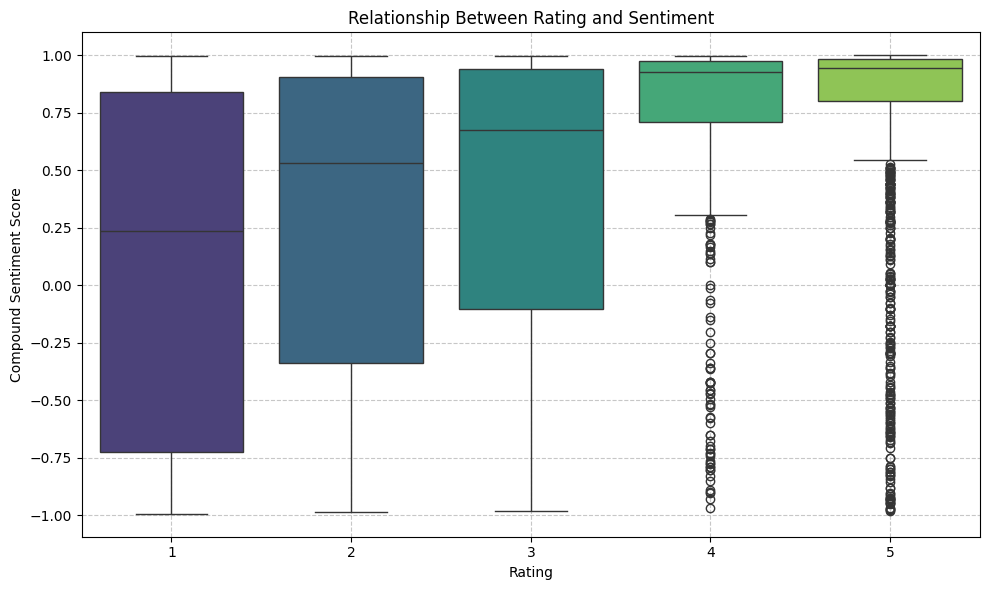

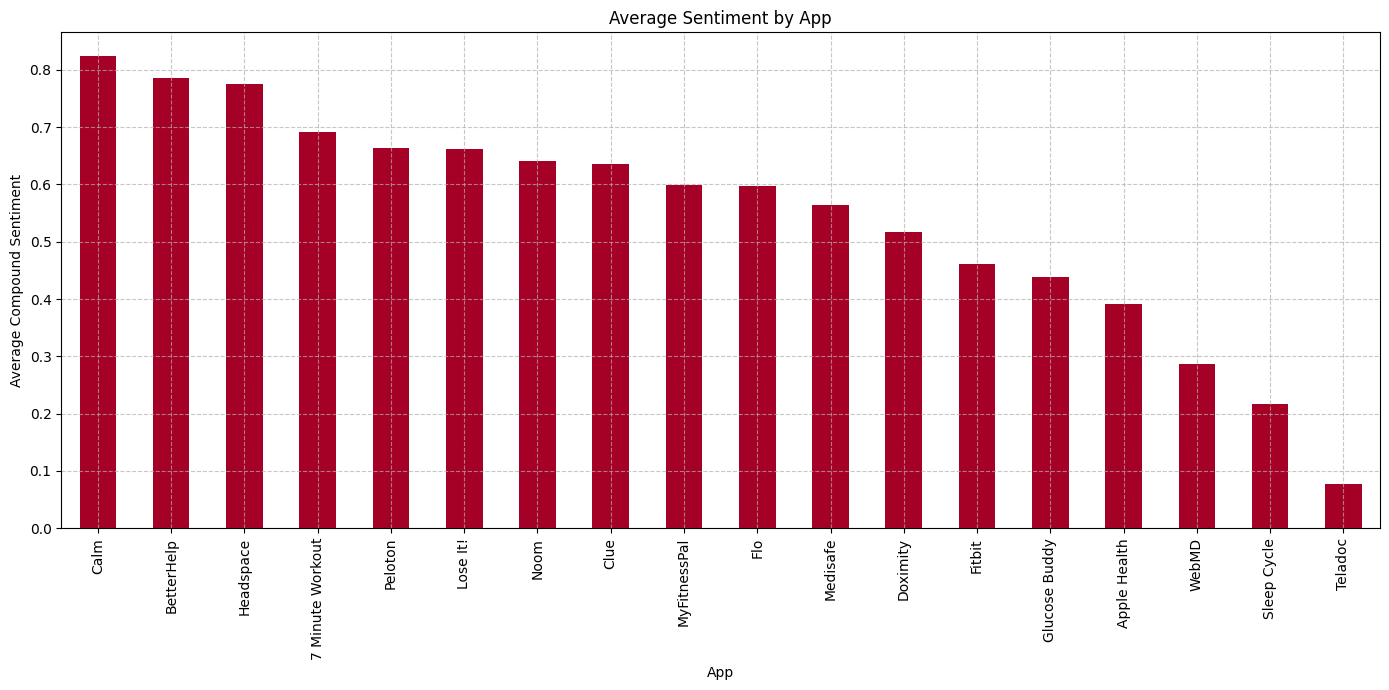

In [11]:
# Sentiment analysis of reviews
if not reviews_df.empty and 'review' in reviews_df.columns:
    # Initialize the sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Apply sentiment analysis to each review
    reviews_df['sentiment_scores'] = reviews_df['clean_review'].apply(lambda x: sia.polarity_scores(str(x)))
    reviews_df['compound_sentiment'] = reviews_df['sentiment_scores'].apply(lambda x: x['compound'])
    
    # Categorize sentiment
    def categorize_sentiment(score):
        if score >= 0.05:
            return 'positive'
        elif score <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    
    reviews_df['sentiment_category'] = reviews_df['compound_sentiment'].apply(categorize_sentiment)
    
    # Plot sentiment distribution
    plt.figure(figsize=(12, 6))
    
    # Sentiment distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x='sentiment_category', data=reviews_df, palette='RdYlGn')
    plt.title('Distribution of Sentiment Categories')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    
    # Compound sentiment distribution
    plt.subplot(1, 2, 2)
    sns.histplot(reviews_df['compound_sentiment'], bins=20, kde=True, color='purple')
    plt.title('Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment Score')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Compare sentiment with ratings
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='rating', y='compound_sentiment', data=reviews_df, palette='viridis')
    plt.title('Relationship Between Rating and Sentiment')
    plt.xlabel('Rating')
    plt.ylabel('Compound Sentiment Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Average sentiment by app
    plt.figure(figsize=(14, 7))
    avg_sentiment = reviews_df.groupby('app_name')['compound_sentiment'].mean().sort_values(ascending=False)
    avg_sentiment.plot(kind='bar', colormap='RdYlGn')
    plt.title('Average Sentiment by App')
    plt.xlabel('App')
    plt.ylabel('Average Compound Sentiment')
    plt.xticks(rotation=90)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

## 7. Word Frequency Analysis

Let's analyze the most common words in the reviews.

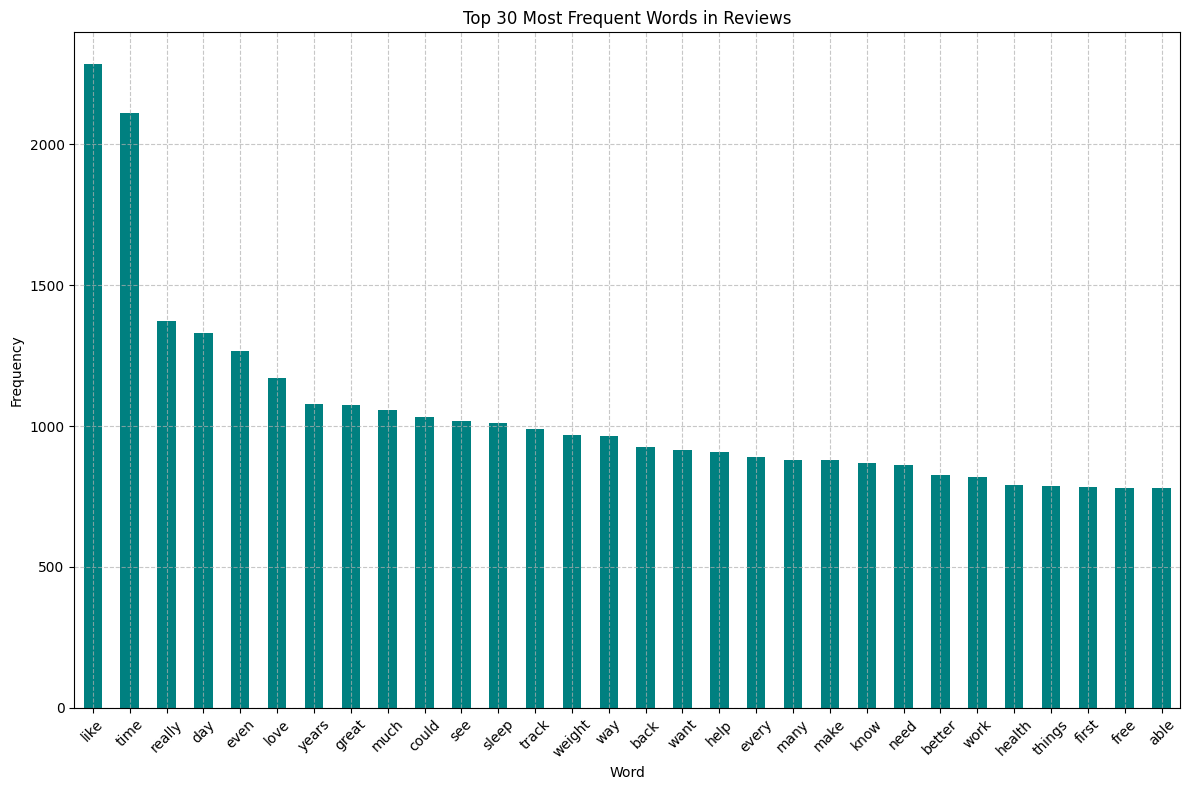

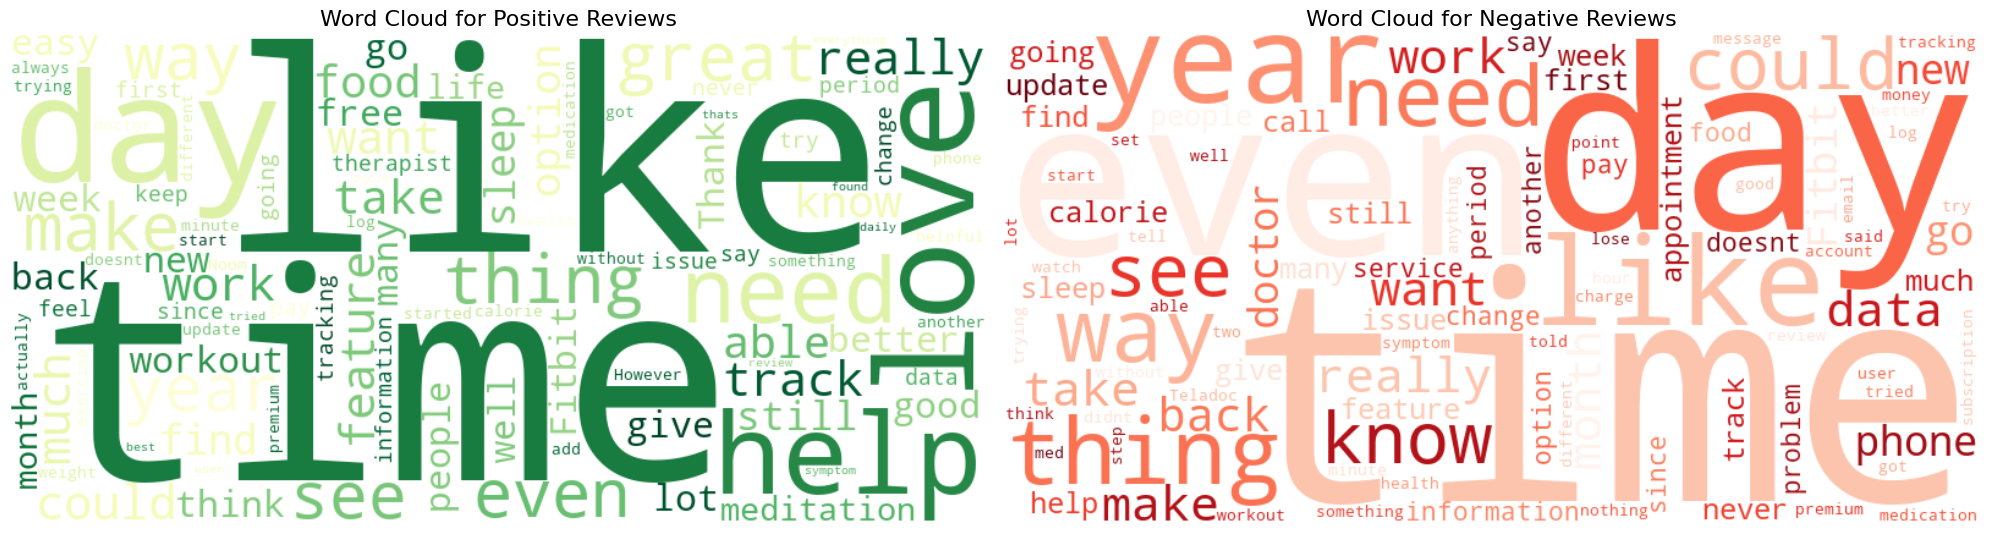

In [12]:
# Word frequency analysis
if not reviews_df.empty and 'clean_review' in reviews_df.columns:
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    additional_stops = {'app', 'apps', 'use', 'using', 'used', 'im', 'ive', 'get', 'also', 'dont', 'cant', 'would', 'one'}
    stop_words.update(additional_stops)
    
    # Tokenize and filter words
    def process_text(text):
        tokens = word_tokenize(str(text).lower())
        return [word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2]
    
    # Apply to all reviews
    all_words = []
    for review in reviews_df['clean_review']:
        all_words.extend(process_text(review))
    
    # Count word frequencies
    word_freq = pd.Series(all_words).value_counts().head(30)
    
    # Plot top words
    plt.figure(figsize=(12, 8))
    word_freq.plot(kind='bar', color='teal')
    plt.title('Top 30 Most Frequent Words in Reviews')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Create word clouds for positive and negative reviews
    plt.figure(figsize=(20, 10))
    
    # Positive reviews word cloud
    positive_reviews = ' '.join(reviews_df[reviews_df['sentiment_category'] == 'positive']['clean_review'])
    if positive_reviews.strip():
        plt.subplot(1, 2, 1)
        wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                                      stopwords=stop_words, max_words=100, colormap='YlGn').generate(positive_reviews)
        plt.imshow(wordcloud_positive, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Positive Reviews', fontsize=16)
    
    # Negative reviews word cloud
    negative_reviews = ' '.join(reviews_df[reviews_df['sentiment_category'] == 'negative']['clean_review'])
    if negative_reviews.strip():
        plt.subplot(1, 2, 2)
        wordcloud_negative = WordCloud(width=800, height=400, background_color='white', 
                                      stopwords=stop_words, max_words=100, colormap='Reds').generate(negative_reviews)
        plt.imshow(wordcloud_negative, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Negative Reviews', fontsize=16)
    
    plt.tight_layout()
    plt.show()

## 8. Comparative Analysis

Let's compare reviews across different apps and categories.

In [13]:
# Comparative analysis across apps
if not reviews_df.empty:
    # Metrics by app
    app_metrics = reviews_df.groupby('app_name').agg({
        'rating': ['mean', 'count'],
        'compound_sentiment': 'mean',
        'review_length': 'mean',
        'word_count': 'mean'
    }).reset_index()
    
    app_metrics.columns = ['app_name', 'avg_rating', 'review_count', 'avg_sentiment', 'avg_review_length', 'avg_word_count']
    app_metrics = app_metrics.sort_values('avg_rating', ascending=False)
    
    # Display app metrics
    app_metrics

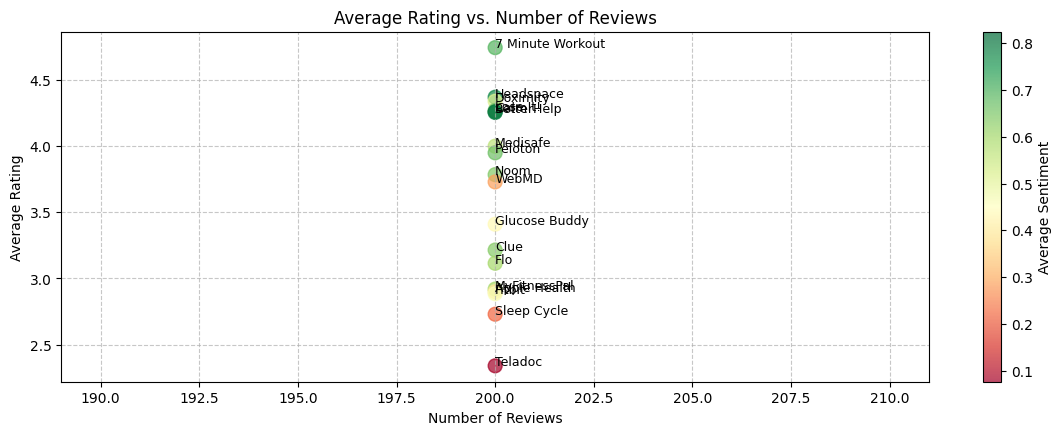

In [14]:
# Plot comparative metrics
if not reviews_df.empty and 'app_metrics' in locals():
    # Top 10 apps by average rating
    top_10_apps = app_metrics.head(10)
    
    plt.figure(figsize=(14, 10))
    
    # Average rating vs. review count
    plt.subplot(2, 1, 1)
    plt.scatter(app_metrics['review_count'], app_metrics['avg_rating'], s=100, alpha=0.7, c=app_metrics['avg_sentiment'], cmap='RdYlGn')
    
    for i, row in app_metrics.iterrows():
        plt.annotate(row['app_name'], (row['review_count'], row['avg_rating']), fontsize=9)
    
    plt.title('Average Rating vs. Number of Reviews')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Average Rating')
    plt.colorbar(label='Average Sentiment')
    plt.grid(True, linestyle='--', alpha=0.7)